# Plotting and analysing model predictions and latents

## Imports and device

In [9]:
import collections
import math
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


## Data loading

In [11]:
folder_path = "C:/Users/Kieran/Documents/Master Thesis Data/Datasets/MouseCentric"

dataframes = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
        
data = pd.concat(dataframes, ignore_index=True)
data = data.drop(columns = ['frame_number'])
data

,"('nose', 'x')","('nose', 'y')","('nose', 'likelihood')","('H1R', 'x')","('H1R', 'y')","('H1R', 'likelihood')","('H2R', 'x')","('H2R', 'y')","('H2R', 'likelihood')","('H1L', 'x')",...,"('tail', 'x')","('tail', 'y')","('tail', 'likelihood')","('S2', 'x')","('S2', 'y')","('S2', 'likelihood')","('S1', 'x')","('S1', 'y')","('S1', 'likelihood')",mouse_no
0,97.501312,72.446838,0.999969,76.267792,76.465271,0.999760,54.404541,76.934204,0.996968,99.304657,...,-94.751236,-99.595276,0.998689,-45.061890,-37.560608,0.994912,292.150818,318.674744,0.995648,11.4
1,94.315247,71.871887,0.999950,73.173645,75.850555,0.999568,55.222382,78.693970,0.997916,96.209991,...,-96.711456,-101.978439,0.999059,-48.097229,-40.080200,0.996069,295.781158,321.270813,0.993003,11.4
2,91.164520,73.615448,0.999945,70.528534,77.226471,0.999638,53.560516,77.271362,0.999153,93.589539,...,-99.503922,-102.734909,0.999419,-49.006653,-42.229187,0.986211,299.371765,323.419800,0.987800,11.4
3,95.102051,70.977386,0.999765,72.682373,74.588409,0.999534,54.546295,74.633301,0.999468,96.380615,...,-101.413986,-103.451233,0.999285,-49.794189,-44.825256,0.981083,303.137299,326.057861,0.994152,11.4
4,110.448181,70.909393,0.999855,91.858368,74.520416,0.999252,70.006622,74.565308,0.998945,108.407593,...,-103.237167,-98.591965,0.999156,-51.617371,-44.893250,0.983985,304.960480,326.125854,0.995609,11.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102495,92.895691,-22.675415,0.999232,85.470825,-11.074768,0.999924,75.502136,-8.060303,0.999492,84.703430,...,-24.412476,116.388947,0.999563,-33.810913,56.276733,0.998793,525.421082,367.743622,0.998882,88.3
1102496,94.005859,-17.802216,0.999680,87.183533,-7.193573,0.999842,75.731262,-6.426147,0.999562,87.588257,...,-24.296509,116.438507,0.999529,-33.658234,56.326294,0.998716,525.653503,367.694061,0.998840,88.3
1102497,106.110474,-17.802216,0.999622,96.254883,-7.193573,0.999950,82.021301,-3.780365,0.999656,94.855774,...,-24.760468,115.177551,0.999215,-33.469727,56.024719,0.999035,525.961548,367.694061,0.998980,88.3
1102498,106.110474,-17.802216,0.999570,96.254883,-7.193573,0.999939,82.021301,-3.780365,0.999616,94.855774,...,-24.760468,114.962799,0.999225,-33.469727,55.950989,0.998865,525.961548,367.694061,0.998603,88.3


In [12]:
dropout_prob   = 0.5
embedding_size = 32
epoch_num      = 10
hidden_size    = 16
layer_num      = 2
learning_rate  = 1e-3
seq_size       = 25 #25 frames is equal to 1 second of video, maybe use 50?

In [13]:
class SeqDataset(Dataset):
    def __init__(self, device, seq_size, dataframe):
        super(SeqDataset, self).__init__()
        self.device    = device
        self.seq_size  = seq_size
        self.dataframe = dataframe
        self.target_data = dataframe.filter(regex='x|y')

    def __len__(self):
        return len(self.dataframe) - self.seq_size - 1

    def __getitem__(self, idx):
        in_seq = torch.tensor(self.dataframe.iloc[idx:idx + self.seq_size].values, dtype=torch.float, device=self.device)
        target_seq = torch.tensor(self.target_data.iloc[idx + 1:idx + self.seq_size + 1].values, dtype=torch.float, device=self.device)
        return in_seq, target_seq

In [14]:
# Split the data into train, validation, and test using the full video sizes (so that videos are not split into different sets)
train_data, test_data = train_test_split(data, test_size= 11250*int(0.2*98), shuffle=False)
n_train_vids = len(train_data)/11250
train_data, val_data = train_test_split(train_data, test_size = 11250 * int(0.1 * n_train_vids), shuffle=False)

# Create SeqDataset instances for the train, validation, and test sets
train_dataset = SeqDataset(device, seq_size, train_data)
val_dataset = SeqDataset(device, seq_size, val_data)
test_dataset = SeqDataset(device, seq_size, test_data)

# Create DataLoader instances for batching
batch_size = 128  # Adjust to your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Creating and loading the model

In [15]:
class Model(nn.Module):
    def __init__(self, dropout_prob, hidden_size, layer_num, input_size, output_size):
        super(Model, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru       = nn.GRU(input_size, hidden_size, layer_num, batch_first=True, dropout=dropout_prob)
        self.linear    = nn.Linear(hidden_size, output_size)

    def forward(self, in_sequence, hidden_state=None):
#         embedding_seq            = self.embedding(in_sequence)
        hidden_seq, hidden_state = self.gru(in_sequence, hidden_state)
        out_seq                  = self.linear(hidden_seq)
        return out_seq, hidden_state
    
    def draw(self, in_sequence, logit_temp=1.0):
        out_seq, _  = self(in_sequence)
        prob_dist   = torch.softmax(out_seq[0, -1] / logit_temp, 0)
        rand_sample = torch.multinomial(prob_dist, 1).item()                   
        return rand_sample

In [16]:
input_size = next(iter(train_loader))[0].size(-1)
print("Input size:", input_size)
output_size = next(iter(train_loader))[1].size(-1)
print("Output size:", output_size)
model = Model(dropout_prob, hidden_size, layer_num, input_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

Input size: 43
Output size: 28


## Running model on test data

## PCA analysis

### Basemodel
The model used was the original base model trained for 10 epochs on the MouseCentric data.

In [17]:
model.load_state_dict(torch.load("model_baseline.pt"))
model.eval

<bound method Module.eval of Model(
  (gru): GRU(43, 16, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=16, out_features=28, bias=True)
)>

In [18]:
dataframes = []
test_loss = 0.0

for in_seq, target_seq in tqdm(test_loader):
    # Get intermediate (latent) output
    lat_seq, _ = model.gru(in_seq)
    
    # Get final predictions
    out_seq = model.linear(lat_seq)
    loss = criterion(out_seq, target_seq)
    test_loss += loss.item()
    
    # Convert the latent and transform to pd
    tensor_np = lat_seq.cpu().detach().numpy()
    output = tensor_np.reshape(-1, tensor_np.shape[-1])
    df = pd.DataFrame(output)
    df['Loss'] = loss.cpu().detach().item()
    dataframes.append(df)
    
test_loss /= len(test_loader)
print(f"Test loss: {test_loss:.4f}")
latents_df = pd.concat(dataframes, axis=0, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1670/1670 [00:31<00:00, 53.69it/s]

Test loss: 893.9926


In [19]:
performance = latents_df['Loss']
latents_df = latents_df.drop('Loss', axis=1)

#### PCA on first batch

In [20]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(latents_df[0:1600])
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

PCA()

The following PCA plots are generated by fitting on just the **first** batch of the test data.

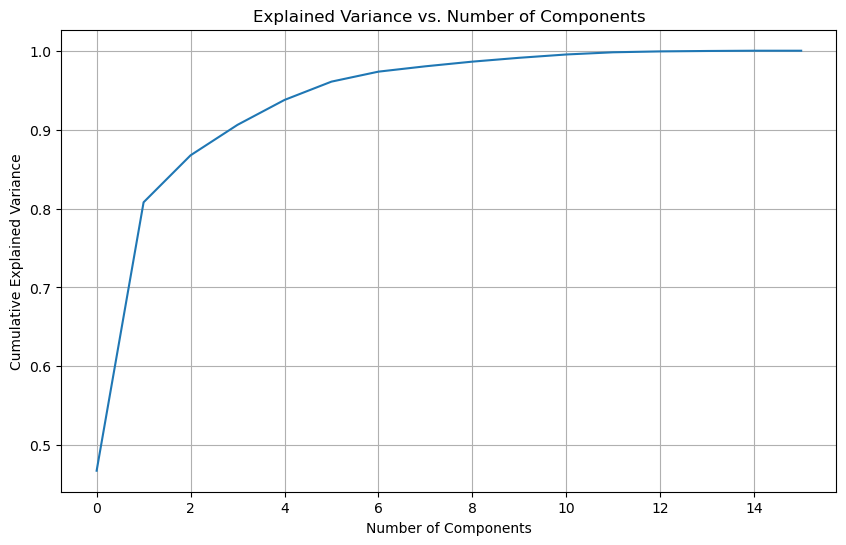

In [21]:
# Get explained variance
explained_variance = pca.explained_variance_ratio_

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

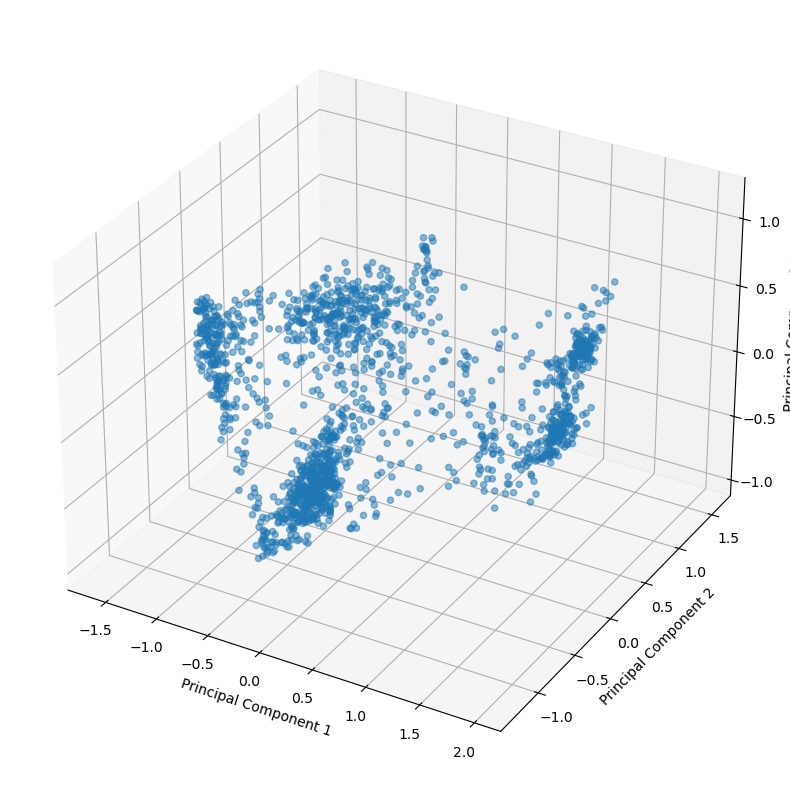

In [22]:
pca2 = pca.fit_transform(latents_df[0:1600])

# Visualizing the results in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca2[:, 0], pca2[:, 1], pca2[:, 2], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('')
plt.show()

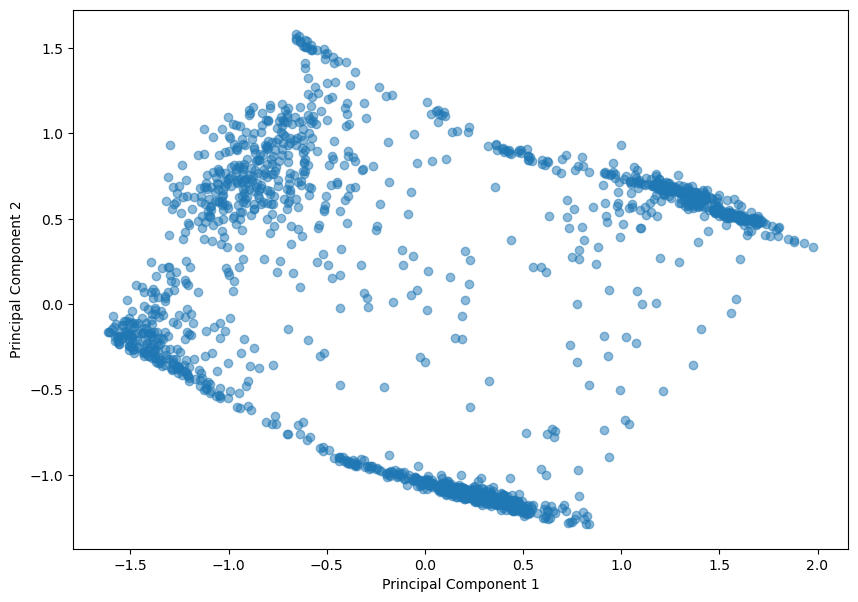

In [23]:
# Visualizing the results in 2D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

ax.scatter(pca2[:, 0], pca2[:, 1], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

ax.set_title('')
plt.show()

#### PCA on all test data
The following plots are on all concatenated batches of the test data

In [24]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(latents_df)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

PCA()

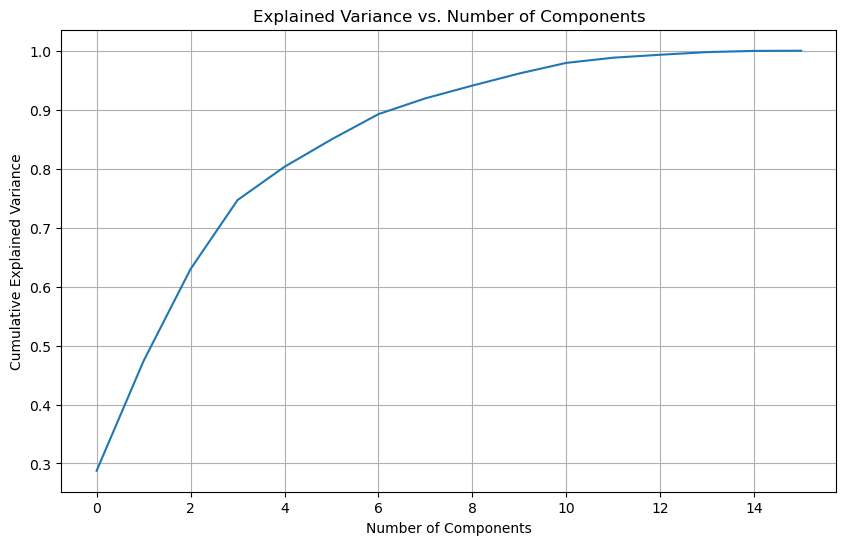

In [25]:
# Get explained variance
explained_variance = pca.explained_variance_ratio_

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [29]:
cmap = plt.get_cmap('RdYlGn')
normalised_performance = 1 - ((performance - performance.min()) / (performance.max() - performance.min()))
# colours = cmap(normalised_performance)

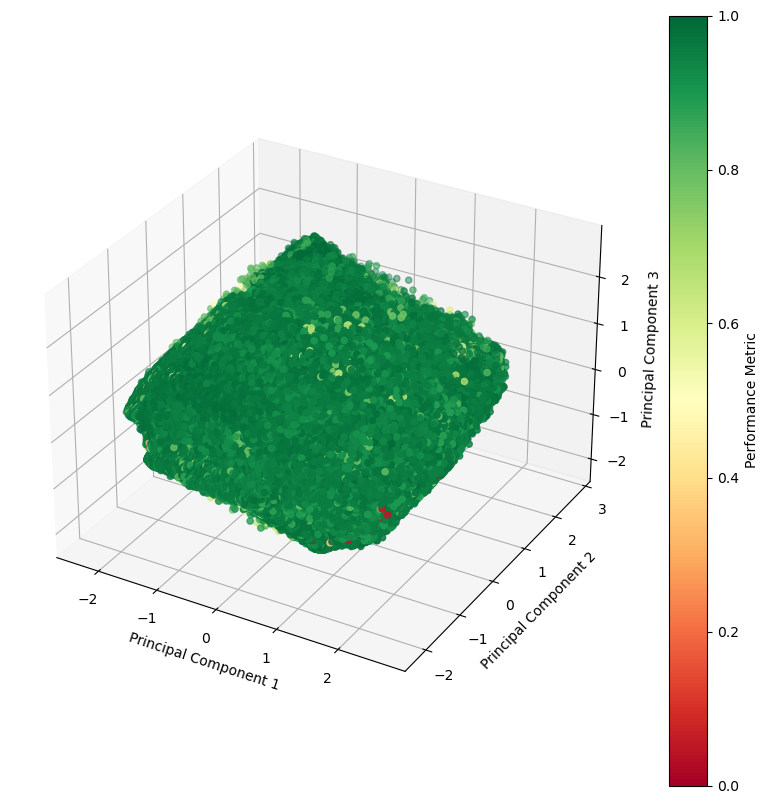

In [30]:
pca2 = pca.fit_transform(latents_df)

# Visualizing the results in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca2[:, 0], pca2[:, 1], pca2[:, 2], c = normalised_performance, cmap = cmap)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('')
cbar = plt.colorbar(scatter)
cbar.set_label('Performance Metric')
plt.show()

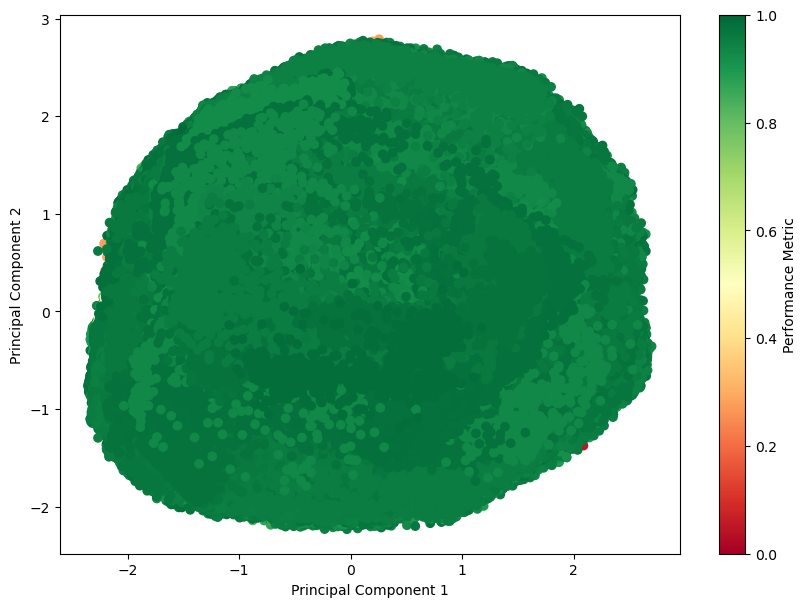

In [31]:
# Visualizing the results in 2D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

scatter = ax.scatter(pca2[:, 0], pca2[:, 1], c = normalised_performance, cmap = cmap)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('')
cbar = plt.colorbar(scatter)
cbar.set_label('Performance Metric')
plt.show()